<a href="https://colab.research.google.com/github/KimYar/Projects/blob/master/CoLA-BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import datetime
import torch

GPU

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The model is loading on a {torch.cuda.get_device_name()}")

The model is loading on a Tesla K80


Data Preprocessing

In [4]:
!pip install transformers

     |████████████████████████████████| 675kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 8.7MB/s 
     |████████████████████████████████| 3.8MB 18.6MB/s 
     |████████████████████████████████| 890kB 33.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=a5aca2510369bc91377c7e2acbe949f361499c789b978c54a51ac9ff7ece3554
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
import os
import requests

url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

print('The file is downloading...')

if not os.path.exists('/content/cola_public_1.1.zip'):
    r = requests.get(url)
    open('/content/cola_public_1.1.zip', 'wb').write(r.content)

if not os.path.exists('cola_public/'):
    !unzip cola_public_1.1.zip

The file is downloading...
Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [6]:
df = pd.read_csv('/content/cola_public/raw/in_domain_train.tsv', sep='\t', header= None, names=['source', 'label', 'label-str', 'sentence'])

In [7]:
sentences = df.sentence.values #longest sentence is 73 char
labels = df.label.values

In [8]:
import transformers
from transformers import BertTokenizer

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case =True)

In [10]:
'''
The below sentence is 47 tokens and is the longest sentence in CoLA dataset
'Everybody who has ever, worked in any office which contained any typewriter which had ever been used to type any letters 
which had to be signed by any administrator who ever worked in any department like mine will know what I mean.'

max_length =0
for sent in sentences:
    input = tokenizer.encode(sent, add_special_tokens=True)
    max_length = max(max_length, len(input))
print(f'The longest sentence in CoLA dataset is: {max_length}')
# The longest sentence in CoLA dataset is: 47
'''

"\nThe below sentence is 47 tokens and is the longest sentence in CoLA dataset\n'Everybody who has ever, worked in any office which contained any typewriter which had ever been used to type any letters \nwhich had to be signed by any administrator who ever worked in any department like mine will know what I mean.'\n\nmax_length =0\nfor sent in sentences:\n    input = tokenizer.encode(sent, add_special_tokens=True)\n    max_length = max(max_length, len(input))\nprint(f'The longest sentence in CoLA dataset is: {max_length}')\n# The longest sentence in CoLA dataset is: 47\n"

Original sentence:    
[CLS] What all did you get for Christmas? [SEP]

---


Token Id:    
[101, 2054, 2035, 2106, 2017, 2131, 2005, 4234, 1029, 102, 0, 0, 0, ... , 0] 

---


Token type id:        
[0, 0, 0, ..., 0, 0, 0, 0, 0] 

---

Attention Mask:       
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0]

In [11]:
input_ids = []
attention_masks = []

for sent in sentences:
 
    encoded_dic = tokenizer.encode_plus(sent, 
                                        add_special_tokens=True,
                                        max_length = 64,
                                        pad_to_max_length = True,
                                        return_attention_mask = True,
                                        return_tensors = 'pt')
    #encoded_dict result is lik {'input_ids: [...], 'token_type_ids: [...], 'attention_mask': [...]}

    input_ids.append(encoded_dic['input_ids'])
    attention_masks.append(encoded_dic['attention_mask'])

input_ids = torch.cat(input_ids, dim=0) # dimension (8551, 64)
attention_masks = torch.cat(attention_masks, dim= 0) # dimension (8551,64)
labels = torch.tensor(labels) # dimension (8551,)


Training

In [12]:
from torch.utils.data import TensorDataset

training_dataset = TensorDataset(input_ids, attention_masks, labels)

In [13]:
from torch.utils.data import DataLoader, RandomSampler

batch_size = 32

train_dataloader = DataLoader(training_dataset, 
                              batch_size= batch_size, 
                              sampler = RandomSampler(training_dataset))

In [14]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 2,
                                                      output_attentions = False,
                                                      output_hidden_states = False)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [15]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

In [16]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
total_steps = epochs * len(train_dataloader)

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [17]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [23]:
for epoch in range(1, epochs+1):

    print(f'Epoch {epoch}/{epochs}')

    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        loss, logits = model(b_input_ids,
                             token_type_ids =None,
                             attention_mask = b_input_mask,
                             labels = b_labels)
        
        total_train_loss += loss.item()
    
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()
        
    avg_train_loss = total_train_loss / len(train_dataloader)
        

Epoch 1/3
Epoch 2/3
Epoch 3/3


Evaluating

In [24]:
df_test = pd.read_csv('/content/cola_public/raw/out_of_domain_dev.tsv', sep='\t', header= None, names=['source', 'label', 'label-str', 'sentence'])

sentences = df_test.sentence.values
labels = df_test.label.values

input_ids = []
attention_masks = []

for sent in sentences:
 
    encoded_dic = tokenizer.encode_plus(sent, 
                                        add_special_tokens=True,
                                        max_length = 64,
                                        pad_to_max_length = True,
                                        return_attention_mask = True,
                                        return_tensors = 'pt')
    #encoded_dict result is lik {'input_ids: [...], 'token_type_ids: [...], 'attention_mask': [...]}

    input_ids.append(encoded_dic['input_ids'])
    attention_masks.append(encoded_dic['attention_mask'])

input_ids = torch.cat(input_ids, dim=0) 
attention_masks = torch.cat(attention_masks, dim= 0) 
labels = torch.tensor(labels)

pred_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

from torch.utils.data import SequentialSampler

pred_sampler = SequentialSampler(pred_dataset)

pred_dataloader = DataLoader(pred_dataset, sampler= pred_sampler, batch_size= batch_size)


In [25]:
len(df_test)

516

In [32]:
model.eval()

predictions , true_labels = [], []

for batch in pred_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():

            output  = model(b_input_ids, 
                                token_type_ids =None, 
                                attention_mask = b_input_mask)
        logits =output[0]   
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
  
        predictions.append(logits)
        true_labels.append(label_ids) 


print('    DONE.')
        

    DONE.


In [33]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):
  
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


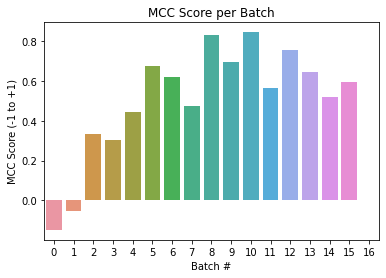

In [35]:
import seaborn as sns
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [36]:
flat_predictions = np.concatenate(predictions, axis=0)

flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = np.concatenate(true_labels, axis=0)

mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.524


Resources:  
http://mccormickml.com    
https://huggingface.co.    
https://www.tensorflow.org     
https://nyu-mll.github.io/CoLA/


